In [1]:
# import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import inspect
import time
import pickle

# access parent directory from notebooks directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import src.simulation as s
import src.utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

In [8]:
# we need to initialize the simulation object, since it contains the network representations
input_args = utils.load_input_args('../input/simulation.json')
simulation =  s.Simulation()

#START CREATE EGO NETWORK DETAILS
def count_identical_tuples(list1, list2):
    count = 0
    for tuple1 in list1:
        if tuple1 in list2:
            count += 1
    return count

df_list = []

for n in simulation.nominationSocialPopulation.graph.nodes():

    l_soc = list(simulation.nominationSocialPopulation.graph.edges(nbunch=n))
    l_com = list(simulation.communicationPopulation.graph.edges(nbunch=n))
    df_list.append([n,count_identical_tuples(l_soc,l_com),len(l_soc),len(l_com)])
#         print(l_soc)
#         print('\n')
#         print(l_com)
#         print('\n')
df_ego_details = pd.DataFrame(df_list, columns = ["ChildID","SameEdges","EdgesPeer","EdgesComm"])
df_ego_details['DiffPeerComm'] = df_ego_details['EdgesPeer'] - df_ego_details['EdgesComm']
df_ego_details['MaxSameEdges'] = df_ego_details[['EdgesPeer','EdgesComm']].max(axis=1)
df_ego_details['PercSameEdges'] = (df_ego_details['SameEdges'] / df_ego_details['MaxSameEdges']) * 100
df_ego_details


# number of participants with more peer edges, compared to more comm edges, compared to equal
len(df_ego_details[df_ego_details['EdgesPeer']>df_ego_details['EdgesComm']]),len(df_ego_details[df_ego_details['EdgesPeer']<df_ego_details['EdgesComm']]),len(df_ego_details[df_ego_details['EdgesPeer']==df_ego_details['EdgesComm']])
#END CREATE EGO NETWORK DETAILS



/Users/davidblok/Work EUR/GitHub/ABM-PA/src/simulation.py:24: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.nominationPopulation = p.PeerNominatedDataPopulation('Peer-Nomination data population', self.input_args)
/Users/davidblok/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidblok/Work EUR/GitHub/ABM-PA/src/simulation.py:25: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.communicationPopulation = p.CommunicationDataPopulation('Communic

(198, 172, 38)

In [3]:
df_nom_soc = pd.DataFrame(columns=['ego', 'alter', 'weight'])
for u,v, data in simulation.nominationSocialPopulation.graph.edges(data=True):
    ego = u
    alter = v
    weight = data['weight']
    df_nom_soc = df_nom_soc.append({'ego': ego, 'alter': alter, 'weight': weight}, ignore_index=True)

df_nom_soc = df_nom_soc.groupby('ego').agg({'alter': 'count', 'weight': 'mean'})

df_nom_soc

,alter,weight
ego,,
1605.0,2,0.750000
1606.0,11,0.409091
1607.0,2,0.500000
1608.0,18,0.513889
1609.0,6,0.416667
...,...,...
6085.0,4,0.500000
6086.0,5,0.600000
6088.0,9,0.527778


In [23]:
#START PLOT 1 CODE
#dataframe showing the number of participants grouped by percentage of same edges - to be used in the plot 1
df_perc_same_edges = df_ego_details.groupby('PercSameEdges')['ChildID'].count().reset_index(name='numChild')

def custom_range(x):
    if x == 0:
        return '0'
    elif x == 100:
        return '100'
    else:
        lower_range = int(x // 10) * 10
        upper_range = lower_range + 9
        return f'{lower_range}-{upper_range}'

# Apply the custom range function to create the Range column
df_perc_same_edges['Range'] = df_perc_same_edges['PercSameEdges'].apply(custom_range)

# Group the data by Range and calculate the sum of numChild
df_grouped = df_perc_same_edges.groupby('Range')['numChild'].sum().reset_index()

# dirty fix to move the fourth label (100) to last row
second_row = df_grouped.iloc[3].copy()
df_grouped = pd.concat([df_grouped.iloc[:3], df_grouped.iloc[4:], second_row.to_frame().T])
# Reset the index
df_grouped = df_grouped.reset_index(drop=True)
df_grouped

,PercSameEdges,numChild,Range
0,0.000000,24,0
1,6.666667,1,0-9
2,7.142857,2,0-9
3,7.692308,1,0-9
4,8.695652,2,0-9
...,...,...,...
77,85.714286,2,80-89
78,87.500000,3,80-89
79,88.888889,3,80-89
80,93.333333,1,90-99


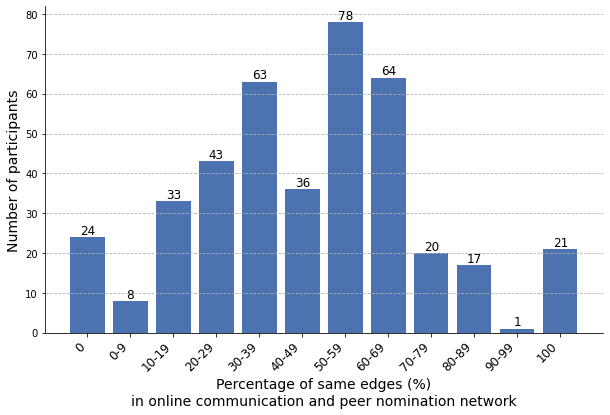

In [30]:
# Set a custom color for the bars
bar_color = '#4c72b0'

# Increase font size by 2 points
font_size = 12

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(df_grouped['Range'], df_grouped['numChild'], width=0.8, color=bar_color, edgecolor='none')

# Set labels and title with increased font size
plt.xlabel('Percentage of same edges (%)\nin online communication and peer nomination network', fontsize=font_size + 2)
plt.ylabel('Number of participants', fontsize=font_size + 2)

# Rotate x-axis labels at 45 degrees with increased font size
plt.xticks(rotation=45, ha='right', fontsize=font_size)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add gridlines
plt.grid(axis='y', linestyle='--')

# Set the plot background color
# plt.gca().set_facecolor('#f0f0f0')

# Add value labels on top of each bar with increased font size
for i, numChild in enumerate(df_grouped['numChild']):
    plt.text(i, numChild, str(numChild), ha='center', va='bottom', fontsize=font_size)


plt.savefig('../output/plots/sameEdges.png', bbox_inches='tight', format='png', dpi=1000)
#END PLOT 1 CODE




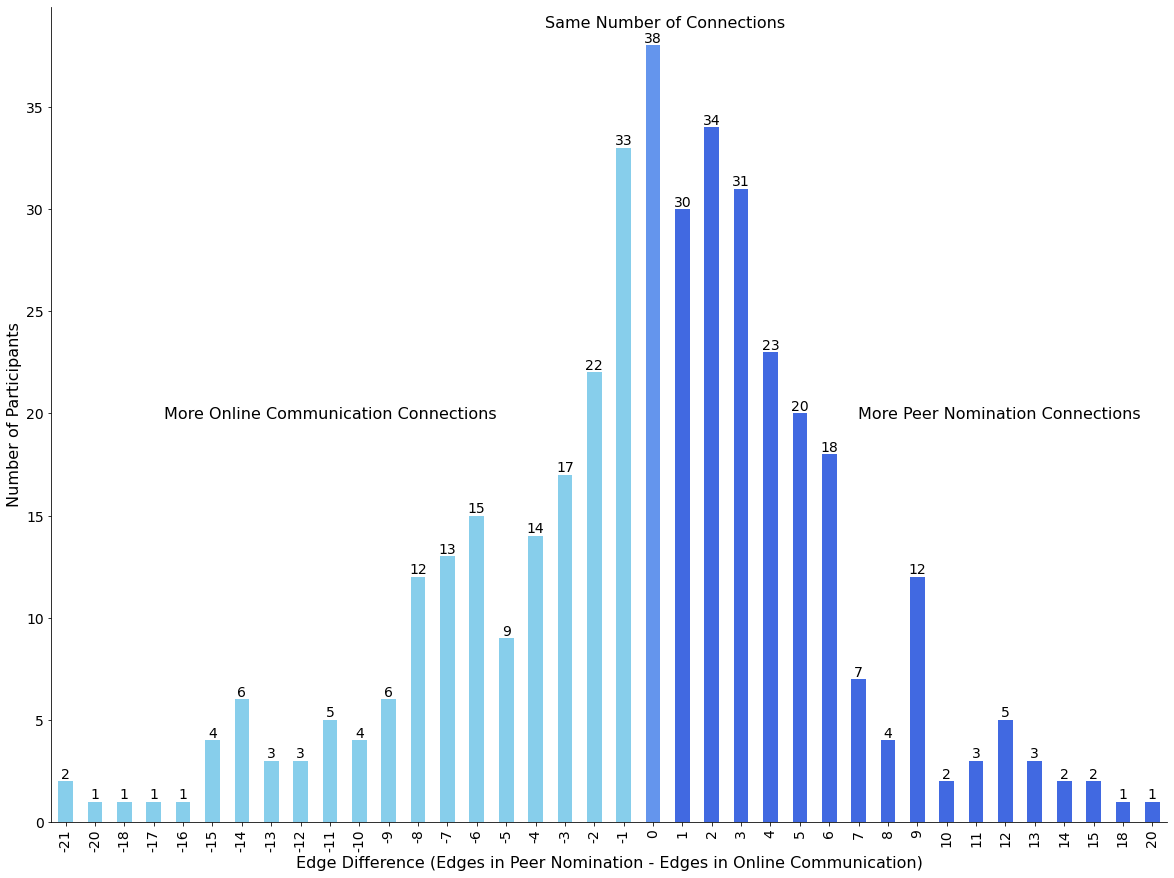

In [32]:
#START PLOT 2 CODE
#dataframe showing the number of participants grouped by DiffPeerComm - to be used in the plot 2
df_diff_edges = df_ego_details.groupby('DiffPeerComm')['ChildID'].count().reset_index(name='numChild')
df_diff_edges.head()

colors = ['#4169E1' if val > 0 else '#87CEEB' if val < 0 else '#6495ED' for val in df_diff_edges['DiffPeerComm']]
ax = df_diff_edges.plot.bar(x='DiffPeerComm', y='numChild', figsize=(20, 15), color=colors, legend=None)
ax.set_ylabel("Number of Participants",fontsize=16)
ax.set_xlabel("Edge Difference (Edges in Peer Nomination - Edges in Online Communication)",fontsize=16)

for index, row in df_diff_edges.iterrows():
    value = row['numChild']
    x_position = index
    y_position = value
    va = 'bottom' if value >= 0 else 'top'  # Set the vertical alignment based on value sign

    ax.text(x_position, y_position, str(value),
            ha='center', va=va, color='black', fontsize=14)
# Remove spines (borders) around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the font size of ticks on both axes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.text(0.55, 0.98, "Same Number of Connections", fontsize=16, ha='center', va='center', transform=ax.transAxes)

plt.text(0.25, 0.5, "More Online Communication Connections", fontsize=16, ha='center', va='center', transform=ax.transAxes)
plt.text(0.85, 0.5, "More Peer Nomination Connections", fontsize=16, ha='center', va='center', transform=ax.transAxes)

plt.savefig('../output/plots/edgeDifference.png', bbox_inches='tight', format='png', dpi=1000)
#END PLOT 2 CODE

/Users/davidblok/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


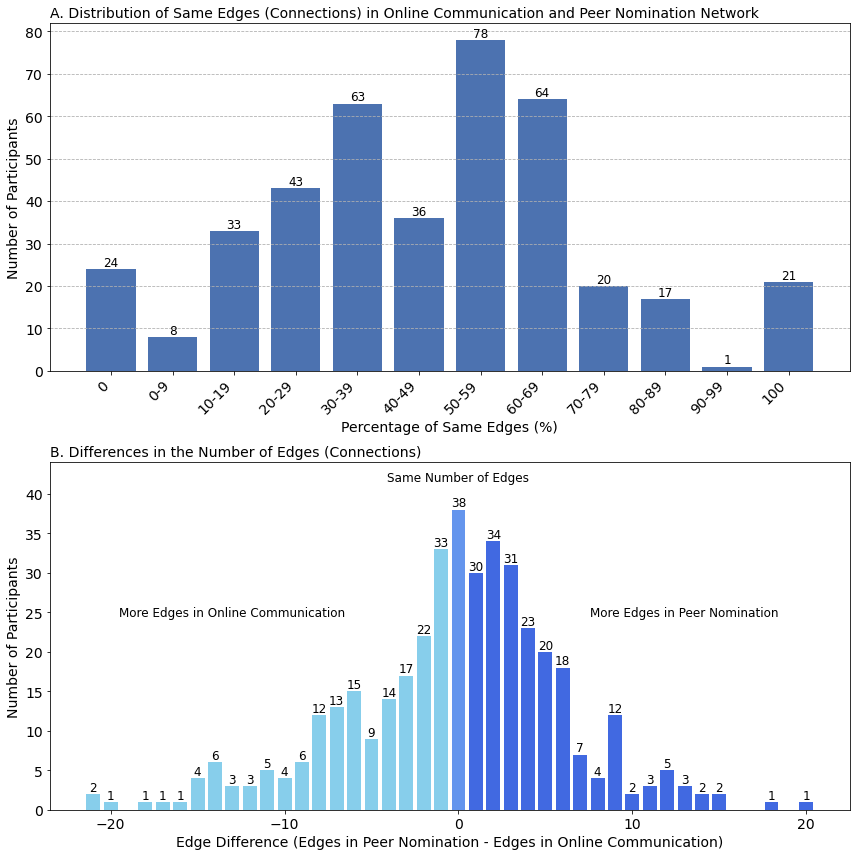

In [85]:
# Combine plots
# Set a custom color for the bars
bar_color = '#4c72b0'
colors = ['#4169E1' if val > 0 else '#87CEEB' if val < 0 else '#6495ED' for val in df_diff_edges['DiffPeerComm']]

# Increase font size by 2 points
font_size = 14

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

# Create the plot
ax1.set_title('A. Distribution of Same Edges (Connections) in Online Communication and Peer Nomination Network', fontsize=font_size, loc='left')
ax1.bar(df_grouped['Range'], df_grouped['numChild'], width=0.8, color=bar_color, edgecolor='none')

# Set labels and title with increased font size
ax1.set_xlabel('Percentage of Same Edges (%)', fontsize=font_size)
ax1.set_ylabel('Number of Participants', fontsize=font_size)

# Rotate x-axis labels at 45 degrees with increased font size
ax1.set_xticklabels(df_grouped['Range'], rotation=45, ha='right', fontsize=font_size)
ax1.tick_params(axis='both', which='both', labelsize=font_size)

# Add gridlines
ax1.grid(axis='y', linestyle='--')

# Add value labels on top of each bar with increased font size
for i, numChild in enumerate(df_grouped['numChild']):
    ax1.text(i, numChild, str(numChild), ha='center', va='bottom', fontsize=12)

# 2nd plot
ax2.set_title('B. Differences in the Number of Edges (Connections)', fontsize=font_size, loc='left')
ax2.set_ylim([0,44])
ax2.bar(df_diff_edges['DiffPeerComm'], df_diff_edges['numChild'], color=colors)
ax2.set_ylabel("Number of Participants",fontsize=font_size)
ax2.set_xlabel("Edge Difference (Edges in Peer Nomination - Edges in Online Communication)",fontsize=font_size)

for index, row in df_diff_edges.iterrows():
    value = row['numChild']
    x_position = row['DiffPeerComm']
    y_position = value
    va = 'bottom' if value >= 0 else 'top'  # Set the vertical alignment based on value sign
    ax2.text(x_position, y_position, str(value),
            ha='center', va=va, color='black', fontsize=12)


# Remove spines (borders) around the plot
#ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

# Set the font size of ticks on both axes
ax2.tick_params(axis='x', labelsize=font_size)
ax2.tick_params(axis='y', labelsize=font_size)

ax2.text(0, 42, "Same Number of Edges", fontsize=12, ha='center', va='center')
ax2.text(-13, 25, "More Edges in Online Communication", fontsize=12, ha='center', va='center')
ax2.text(13, 25, "More Edges in Peer Nomination", fontsize=12, ha='center', va='center')

fig.tight_layout()

In [86]:
fig.savefig('../output/plots/edgeDifference.png', bbox_inches='tight', format='png', dpi=1000)